Analysis of Clustering in the San Diego homeless population
by Derek O'Connor, 11/26/19

First we need to install required packages. 

In [0]:
!pip install geopandas 
!pip install ipyleaflet
!pip install git+https://github.com/python-visualization/folium
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import shapely
import shapely.wkt
import random
import folium
from folium.plugins import HeatMap 
from folium.plugins import MarkerCluster
from google.colab import widgets
from google.colab import files
from shapely import geometry
from shapely.geometry import Point, Polygon, box
from math import sqrt, asin, sin, cos, atan2, radians, degrees
from math import ceil

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

We import the data sets as geopandas dataframes which are well suited for geographic data: you can specify a coordinate reference system 'crs' and add a 'geometry' column for coordinates (points, polygon... )

In [0]:
# Importing relevant data files from SD_homeless_project repository: https://github.com/joddle/SD_homeless_project
# ... using pandas to import as dataframe, and converting to geopandas dataframe

# 3/16/20
# the following syntax is deprecated: crs={'init':'epsg:4326'}

# Homeless counts data originally downloaded from: http://library.metatab.org/sandiegodata.org-dowtown_homeless-1.csv
# homeless_df = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/sandiegodata.org-dowtown_homeless-1/data/homeless_counts.csv?raw=true')
# homeless_df = gpd.GeoDataFrame(homeless_df, crs={'init':'epsg:4326'})

homeless_df = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/sandiegodata.org-dowtown_homeless-8/data/homeless_counts.csv?raw=true')
homeless_df = gpd.GeoDataFrame(homeless_df)
homeless_df.crs = 'epsg:4326'

# MTS stop locations data originally downloaded from: https://www.sdmts.com/google_transit_files/google_transit.zip
mts_stops_df = pd.read_csv('https://raw.githubusercontent.com/joddle/SD_homeless_project/master/google_transit/stops.txt')

# mts_stops_df = gpd.GeoDataFrame(mts_stops_df, crs={'init':'epsg:4326'}, geometry=gpd.points_from_xy(mts_stops_df.stop_lon, mts_stops_df.stop_lat))
mts_stops_df = gpd.GeoDataFrame(mts_stops_df, geometry=gpd.points_from_xy(mts_stops_df.stop_lon, mts_stops_df.stop_lat))
mts_stops_df.crs = 'epsg:4326'

# imputed homeless counts data originally downloaded from: http://library.metatab.org/sandiegodata.org-dowtown_homeless-8.csv
homeless_imputed_df = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/sandiegodata.org-dowtown_homeless-8/data/imputed_counts.csv?raw=true')
homeless_imputed_df = gpd.GeoDataFrame(homeless_imputed_df)
homeless_imputed_df.crs = 'epsg:4326'

In [0]:
homeless_df.head()

In [0]:
# Data visualizations: Missing Data 
# a large percentage of temperature and rain data is missing 
homeless_df.info()

In [0]:
homeless_imputed_df.head()
homeless_imputed_df.info()

In [0]:
sns.heatmap(homeless_df.isnull(), cbar=False)

In [0]:
# determine if the location of missing values has correlation with any other variables
fig, ax = plt.subplots(figsize=(5,5))
msno.heatmap(homeless_df, ax=ax)

In [0]:
sns.heatmap(homeless_imputed_df.isnull(), cbar=False)

In [0]:
# determine if the location of missing values has correlation with any other variables
fig, ax = plt.subplots(figsize=(5,5))
msno.heatmap(homeless_imputed_df, ax=ax)

In [0]:
mts_stops_df.head()

In [0]:
mts_stops_df = mts_stops_df[['stop_lon', 'stop_lat', 'geometry']]
mts_stops_df = mts_stops_df.rename(columns={'stop_lon': 'lon', 'stop_lat': 'lat'})

We create a function that isolates the reference points to be in the polygon of the downtown San Diego area by [latitude, longitude]. 

In [0]:
# this function takes in a reference gdf with 'lat', 'lon', 'geometry' columns
# and returns a gdf with columns within the SD polygon specified in the function
def get_ref_points_in_polygon(ref_df):
  # created a square polygon manually from http://apps.headwallphotonics.com/
  # to encompass downtown SD approximately (an exact polygon would be ideal)
  downtown_sd_polygon = Polygon([[-117.14498519897461, 32.72772530667563],
                            [-117.14469100989061, 32.70399523704015],
                            [-117.1773066715117, 32.70385078849076],
                            [-117.1773066715117, 32.72775384006868]])
  # type(downtown_sd_polygon)
  # print(downtown_sd_polygon.wkt)
  downtown_index = []
  for i in range(len(ref_df.index)):
    if downtown_sd_polygon.contains(ref_df['geometry'][i]):
      downtown_index.append(i)
  # print(downtown_index)
  downtown_ref_df = ref_df.iloc[downtown_index].reset_index(drop = True)
  return downtown_ref_df

In [37]:
downtown_mts_stops_df = get_ref_points_in_polygon(mts_stops_df)
downtown_mts_stops_df

lon        lat                     geometry
0   -117.166685  32.715569  POINT (-117.16668 32.71557)
1   -117.164952  32.715598  POINT (-117.16495 32.71560)
2   -117.162107  32.715614  POINT (-117.16211 32.71561)
3   -117.160297  32.715660  POINT (-117.16030 32.71566)
4   -117.159474  32.715664  POINT (-117.15947 32.71566)
..          ...        ...                          ...
154 -117.159474  32.706824  POINT (-117.15947 32.70682)
155 -117.152875  32.705685  POINT (-117.15287 32.70568)
156 -117.153993  32.711537  POINT (-117.15399 32.71154)
157 -117.168759  32.712101  POINT (-117.16876 32.71210)
158 -117.169965  32.717003  POINT (-117.16996 32.71700)

[159 rows x 3 columns]

To display coordinates of observations (the homeless population) on a Folium heat map, we take the original polygons of each observed homeless person/group, extract a single point by taking the centroid of the polygon, and output a dataframe with latitude, longitude, as well as output an array with latitude, longitude columns.

In [0]:
# this function takes in a dataframe with a 'geometry' feature, extracts the latitude and longitude, 
# and outputs a df with ['lat', 'lon']  features as well as an array of ['lat', 'lon'] values 
# that can be parsed by the folium library to generate heatmaps
def getLatLonforHeatMap(homeless_df):
  homeless_polygon = homeless_df['geometry']
  homeless_polygon_list = []
  # polygon coordinates are strings and need to be parsed
  # convert str into polygon type and then find centroid of this polygon as a point
  for polygon in homeless_polygon:
    homeless_polygon_list.append(shapely.wkt.loads(polygon))
  homeless_points = [polygon.centroid for polygon in homeless_polygon_list]
  homeless_lat_lon = pd.DataFrame({'lon':[point.x for point in homeless_points], 'lat':[point.y for point in homeless_points], 'geometry': homeless_points})
  homeless_array = homeless_lat_lon[['lat', 'lon']].values
  return homeless_lat_lon, homeless_array

Here we begin defining functions for a simulated data set of how the homeless population could be distributed around the reference points (MTS bus stops) assuming the relationship between the observations and reference points has statistical signifiance.

We define a function getPointsDF that creates a dataframe containing only Point objects (latitude, longitude) 


In [0]:
def getPointsDF(homeless_df):
  homeless_polygon = homeless_df['geometry']
  homeless_polygon_list = []
  # polygon coordinates are strings and need to be parsed
  # convert str into polygon type and then find centroid of this polygon as a point
  for polygon in homeless_polygon:
    homeless_polygon_list.append(shapely.wkt.loads(polygon))
  homeless_points = [polygon.centroid for polygon in homeless_polygon_list]
  return pd.DataFrame({'Points': homeless_points})

In [40]:
homeless_points = getPointsDF(homeless_df)
homeless_points.head()

Points
0  POINT (-117.1569281901652 32.71077996980736)
1  POINT (-117.1569281901652 32.71077996980736)
2  POINT (-117.1569281901652 32.71077996980736)
3  POINT (-117.1569281901652 32.71077996980736)
4  POINT (-117.1569281901652 32.71077996980736)

In [0]:
# Get lat/lon coordinates of homeless data
# homeless_polygon = homeless_df['geometry']
# type(homeless_polygon[0])

# polygon coordinates are strings and need to be parsed
# P = homeless_polygon[0]
# type(P)

# example: I want to convert a str into a polygon type
# ... and then find centroid of this polygon as a point
# P = shapely.wkt.loads('POLYGON ((51.0 3.0, 51.3 3.61, 51.3 3.0, 51.0 3.0))')
# print(P.centroid)

# type(homeless_polygon_list[0])

We create a function generating a Folium map that displays the reference points (MTs bus stops) and a heatmap of the observations (homeless popululation) within the downtown San Diego area. 

In [0]:
# Create map object with reference points
def make_ref_points_basemap(ref_points_df = downtown_mts_stops_df, default_loc = [32.7173, -117.1694], default_tiles = 'stamentoner', default_zoom = 13):
  ref_points_basemap = folium.Map(location = default_loc, tiles = default_tiles, zoom_start = default_zoom, control_scale = True)
  # add markers for the mts stations 
  for index, row in ref_points_df.iterrows():
    folium.CircleMarker([row['lat'], row['lon']],
                      radius = 1,
                      color = 'red',
                      fill_color = 'red',
                      ).add_to(ref_points_basemap)
  return ref_points_basemap

In [42]:
homeless_heatmap = make_ref_points_basemap()

# add the heatmap using the homeless array of lat/lon
# folium seems to have difficulty creating heatmaps for more than ~35,000 points

random.seed(42)
homeless_lat_lon_df, homeless_array = getLatLonforHeatMap(homeless_df)
homeless_array_subset = homeless_array[random.sample(range(0,len(homeless_array)), 35000)]

# heatmap = HeatMap(homeless_array).add_to(m)
homeless_heatmap.add_child(HeatMap(homeless_array_subset, radius=5))

# display heatmap
homeless_heatmap

In [44]:
homeless_imputed_heatmap = make_ref_points_basemap()

# add the heatmap using the homeless array of lat/lon
# folium seems to have difficulty creating heatmaps for more than ~30,000 points

random.seed(42)
homeless_imputed_lat_lon_df, homeless_imputed_array = getLatLonforHeatMap(homeless_df)
homeless_imputed_array_subset = homeless_imputed_array[random.sample(range(0,len(homeless_imputed_array)), 35000)]

homeless_imputed_heatmap.add_child(HeatMap(homeless_imputed_array_subset, radius=5))

# display heatmap
homeless_imputed_heatmap

We now start creating functions for the purpose of the simulation. These two functions work together to calculate the distance between any two points on a map. 

In [0]:
# in order to do statistical signifance testing we need a metric of spread of the data
# we will run a number of simulations and plot a histogram of the ANN (average nearest neighbors) value
# 
# Reference: https://mgimond.github.io/Spatial/hypothesis-testing.html#alternatives-to-csrirp

# helper functions for calculating haversine distance between two points (lat1, lat2), (lon1, lon2)
def haversine(angle_radians):
  return (sin(angle_radians / 2))**2
def get_haversine_dist(lat1, lon1, lat2, lon2):
  lat1, lat2 = radians(lat1), radians(lat2)
  lon1, lon2 = radians(lon1), radians(lon2)
  radius_earth = 6.371*pow(10,6)
  return 2*radius_earth*asin(sqrt(haversine(lat2 - lat1) + cos(lat1)*cos(lat2)*haversine(lon2 - lon1)))

This function generates a simulated observation point around a reference point.

In [0]:
# given a starting latitude and longitude, bearing angle (in units of DEGREES),
# as well as distance (in units of METERS)
# this function generates the ending latitude and longitude (in degrees)
# using the following formula (which has input and output in units of RADIANS)
# φ2 = asin(sin φ1 ⋅ cos δ + cos φ1 ⋅ sin δ ⋅ cos θ )
# λ2 = λ1 + atan2(sin θ ⋅ sin δ ⋅ cos φ1, cos δ − sin φ1 ⋅ sin φ2)
# where	φ is latitude, λ is longitude, θ is the bearing (clockwise from north), 
# δ is the angular distance d/R; d being the distance travelled, R the earth’s radius
# Reference: https://www.movable-type.co.uk/scripts/latlong.html

def generateNewPoint(lat1, lon1, distance, bearing):
  lat1 = radians(lat1)
  lon1 = radians(lon1)
  bearing = radians(bearing)
  radius_Earth = 6.371*pow(10,6)
  angular_dist = distance / radius_Earth
  lat2 = asin(sin(lat1) * cos(angular_dist) + cos(lat1) * sin(angular_dist) * cos(bearing))
  lon2 = lon1 + atan2(sin(bearing) * sin(angular_dist) * cos(lon1), cos(angular_dist) - sin(lat1) * sin(lat2))
  return degrees(lat2), degrees(lon2)
  

We test that the above function works by generating equally spaced points around a reference point. It appears as an ellipse on the map but is circular in reality due to the distorted projection of the map. 

In [49]:
# Note: mercator projection is distorted which is why a sequence of points the same distance from the starting point 
# appear to form an ellipse when in reality it is close to being a circle 
# (on the earth's curved plane which is essentially flat for such short distances)
testmap = make_ref_points_basemap(default_zoom = 16)
lat_start, lon_start = downtown_mts_stops_df['lat'][0], downtown_mts_stops_df['lon'][0]
folium.CircleMarker([lat_start, lon_start],
                      radius = 1,
                      color = 'blue',
                      fill_color = 'blue',
                      ).add_to(testmap)
for bearing in range(0, 360, 4):
  lat_end, lon_end = generateNewPoint(lat_start, lon_start, 400, bearing)
  folium.CircleMarker([lat_end, lon_end],
                      radius = 1,
                      color = 'green',
                      fill_color = 'green',
                      ).add_to(testmap)
testmap


We calculate the percentage of observations at each reference point to help us create a simulation following the same 
population distribution.

In [0]:
# the following function calculates the approximate population density of each reference point
# relative to the observed points by looping through each reference point, 
# counting the number of observations within an upper_dist of the reference point
# then dividing through by the total number of observations counted
# NOTE: this does not account for population overlap...
# ... but we will consider the effect negligible on getting approximate densities for the reference points
def get_ref_densities(ref_points_df, points_df, upper_dist = 400):
  ref_points_counts = []
  for index, ref_row in ref_points_df.iterrows():
    count = 0
    for index, obs_row in points_df.iterrows():
      if get_haversine_dist(ref_row['lat'], ref_row['lon'], obs_row['lat'], obs_row['lon']) <= upper_dist:
        count = count + 1
    ref_points_counts.append(count)
  total_obs = sum(ref_points_counts)
  ref_density_list = [ref_points_count / total_obs for ref_points_count in ref_points_counts]
  ref_points_densities = pd.DataFrame({'density': ref_density_list})
  return pd.concat([ref_points_df, ref_points_densities], axis=1)

In [0]:
ref_points_df = get_ref_densities(downtown_mts_stops_df, homeless_lat_lon_df)

In [0]:
# ref_points_densities['density'] * 1000

In [0]:
# ref_points_densities.to_csv('ref_points_densities.csv')
# files.download('ref_points_densities.csv')

The above calculation takes awhile... so I have the density for each reference point ready to download. 

In [53]:
ref_points_density_df = pd.read_csv('https://raw.githubusercontent.com/joddle/SD_homeless_project/master/ref_points_densities.csv')
ref_points_density_df = ref_points_density_df[['lon', 'lat', 'geometry', 'density']]
ref_points_density_df.head()


lon        lat                                   geometry   density
0 -117.166685  32.715569  POINT (-117.166684700734 32.715568901987)  0.004292
1 -117.164952  32.715598   POINT (-117.164952101716 32.71559825863)  0.006544
2 -117.162107  32.715614  POINT (-117.162107439238 32.715613832073)  0.007501
3 -117.160297  32.715660  POINT (-117.160296984597 32.715660190144)  0.010503
4 -117.159474  32.715664   POINT (-117.15947445809 32.715663509792)  0.010178

We generate simulated points around each reference point. There are some assumptions that can be fine-tuned: (1) the observations distance from each reference point is normally distributed (more points closer to the reference point, fewer points further away), (2) the number of points to be simulated around each reference point follows the percentage (density) of observations around each reference point. 

In [0]:
# this function takes in a ref_points_df that more points are to be generated around
# in the MTS stops research, we will generate points with radii normally distributed around each MTS stop
# ... there will be an argument to check whether each point is within the border of interest (in this case downtown SD)

# since the normal distribution represents the distance from the center of each stop
# it should be centered at 0 with a standard deviation that contains most of the data

# taking a 5-minute walk from each bus stop to be approximately 400 meters, 
# we expect 400 meters to be the distance most homeless people would be from each stop
# therefore we set 400 meters = 2 standard deviations or 95% of the observed data points, making the std_dev = 200

# the argument upper_distance will be 2 standard deviations so sigma = max_distance / 2

# the number of points simulated around each stop approximately matches the density of the homeless population found around the stops
# as calculated from the get_ref_densities function
# each reference point's relative density is multiplied by the total_points to determine 
# the number of simulated points (rounded up to the nearest integer) to be generated around each reference point 
def get_simulated_points(ref_points_density_df = ref_points_density_df, border = None, total_points = 10000, upper_dist = 400):
  mu, sigma = 0, upper_dist / 2.0
  lats_list = []
  lons_list = []
  random.seed(411)
  for index, row in ref_points_density_df.iterrows():
    number_of_points = int(ceil(total_points * row['density']))
    radii_rand = np.random.normal(mu, sigma, number_of_points)
    bearings_rand = 360.0 * np.random.ranf(number_of_points)
    for j in range(number_of_points):
      lat_new, lon_new = generateNewPoint(row['lat'], row['lon'], radii_rand[j], bearings_rand[j])
      lats_list.append(lat_new)
      lons_list.append(lon_new)
  return pd.DataFrame({'lat': lats_list, 'lon': lons_list})

Display the 10,000 simulated observations on the base Folium map we created earlier that also shows the reference points. The clustering occurs around the reference points which is a basic assumption built into our simulation. 

In [57]:
simulated_points_df = get_simulated_points(ref_points_density_df = ref_points_density_df, border = None, total_points = 10000, upper_dist = 400)
simulated_points_array = simulated_points_df[['lat', 'lon']].values
simulated_points_heatmap = make_ref_points_basemap()
simulated_points_heatmap.add_child(HeatMap(simulated_points_array, radius = 5))

In [58]:
simulated_points_df.head()

lat         lon
0  32.717591 -117.166483
1  32.716025 -117.165463
2  32.714609 -117.166009
3  32.715375 -117.166860
4  32.714592 -117.165210

In [61]:
homeless_gpd = gpd.GeoDataFrame(homeless_lat_lon_df)
homeless_gpd.crs = 'epsg:4326'
homeless_gpd.head()

lon       lat                     geometry
0 -117.156928  32.71078  POINT (-117.15693 32.71078)
1 -117.156928  32.71078  POINT (-117.15693 32.71078)
2 -117.156928  32.71078  POINT (-117.15693 32.71078)
3 -117.156928  32.71078  POINT (-117.15693 32.71078)
4 -117.156928  32.71078  POINT (-117.15693 32.71078)

We now start writing functions that will help us determine if the simulated points are similar to the observed points. To do this we calculate a statistic called average nearest neighbors (ANN): it is done by finding the cumulative distance between an observation and all of the stops and dividing by the number of stops, then finding the sum of all of these average distances for every single point, and dividing by the number of points. This value is then divided by the area of the minimum bounding rectangle around the data set to ensure a more "relative" comparison between different data sets. 

Conceptually, the ANN measures the spread of a data set around reference points. 

In [62]:
(min_lon, min_lat, max_lon, max_lat) = homeless_gpd['geometry'].total_bounds
lat_dist = get_haversine_dist(min_lat, min_lon, max_lat, min_lon)
lon_dist = get_haversine_dist(min_lat, min_lon, min_lat, max_lon)
area = lat_dist * lon_dist
area

5078456.899255992

In [0]:
# get_haversine_dist(36.12, -86.67, 33.94, -118.40)
# generateNewPoint(36.12, -86.67, 10, 180)
# get_haversine_dist(36.12, -86.67, 36.119910067839406, -86.67)
# should come out to approximately 10 meters 

*This* function calculates a bounding rectangle of a data set. However it is not a minimum bounding rectangle because the rectangle is always aligned to north, south, east, and west. Generally this should produce larger rectangles for more spread out areas, but there could be a situation where a smaller bounding rectangle could be created for data that is, say, elliptical and facing northeast (at a 45˚ angle)

In [0]:
# this function takes in a series of points from a df, and returns the bounded rectangle area
# this is very much an approximation and is not the minimum bounding rectangle...
# ... however a larger rectangle will be returned for more spread out data in general 
# ... which is the reasoning behind dividing through by the rectangle's area in the ANN equation

# this oversimplification of the bounding rectangle area is strongly influenced by the presence of any outliers 
# this bounding rectangle also is strongly influenced by the shape of the data 
# (e.g. sideways elongated ellipse can have a much larger rectangle area than if we use the minimum bounding rectangle)

# check to make sure 'Points' column exists
def get_bounded_rect(points_df):
  if('Points' not in points_df.columns.values):
    print('No \'Points\' column in dataframe')
    print('Creating \'Points\' column from \'lat\' and \'lon\' columns...')
    homeless_gpd = gpd.GeoDataFrame(points_df, crs={'init':'epsg:4326'}, geometry = gpd.points_from_xy(points_df.lon, points_df.lat))
  else:
    homeless_gpd = gpd.GeoDataFrame(points_df, crs={'init':'epsg:4326'})
    homeless_gpd.rename(columns={'Points': 'geometry'}, inplace = True) 
  (min_lon, min_lat, max_lon, max_lat) = homeless_gpd['geometry'].total_bounds
  lat_dist = get_haversine_dist(min_lat, min_lon, max_lat, min_lon)
  lon_dist = get_haversine_dist(min_lat, min_lon, min_lat, max_lon)
  return lat_dist * lon_dist

In [0]:
# the following function takes a df of points and calculates the average nearest neighbors 
# from the df of points to each of the points in the df ref_pts (mts stops in this case)
# ... this metric is given by the average of the haversine distances between each observation and all reference points
# ANN ratio = D(O) / D(E) where D(O) is the mean of the sum of distances between each feature and its nearest neighbor
# ... and D(E) is the expected mean distance for features given by 0.5 / sqrt(n/A) 

# D(E) = 0.5 / sqrt(n/A) 
# where n is the total number of observations and A is the area of the minimum enclosing rectangle around the points

# The minimum bounding rectangle for the observed points *could* be significantly smaller 
# than the minimum bounding rectangle for the simulated points... so this should 
# make the ANN values more "relative" to each other and therefore comparable 

def get_ANN(points_df, ref_points_df):
  sum_NN = 0
  start = time.time()
  for one_index, one_row in points_df.iterrows():
    for other_index, other_row in ref_points_df.iterrows():
      sum_NN = sum_NN + get_haversine_dist(one_row['lat'], one_row['lon'], other_row['lat'], other_row['lon'])
    if one_index % 1000 == 0:
      end = time.time()
      print('Calculated ANN for point', one_index, 'of', len(points_df.index), 'in', end - start, 'seconds')
  mean_dist_obs = sum_NN / len(points_df.index)
  mean_dist_exp = 0.5 / sqrt(len(points_df.index) / get_bounded_rect(points_df))
  return mean_dist_obs / mean_dist_exp

In [0]:
def get_simulated_ANNs(ref_points_df, number_of_cycles = 100, points_per_ref = 5):
  simulated_ANNs = []
  for cycle in range(number_of_cycles):
    start = time.time()
    simulated_points_df = get_simulated_points(border = None, total_points = 10000, upper_dist = 400)
    simulated_ANNs.append(get_ANN(simulated_points_df, ref_points_df))
    end = time.time()
    print('finished simulation', cycle+1, 'in', end - start, 'seconds')
  return simulated_ANNs

In [0]:
simulated_points_df.head()

In [0]:
get_ANN(points_df = simulated_points_df[1:100], ref_points_df = downtown_mts_stops_df)

No 'Points' column in dataframe
Creating 'Points' column from 'lat' and 'lon' columns...


3799.1162450450706

In [0]:
simulated_ANNs = get_simulated_ANNs(ref_points_df = downtown_mts_stops_df, number_of_cycles = 100, points_per_ref = 30)

In [0]:
def plot_simulated_ANNs_and_observed_ANN(simulated_ANNs, observed_ANN):
  simulated_points_array = np.asarray(simulated_ANNs)
  # if all simulated points smaller than observed, a broken axis can be helpful:
  if simulated_ANNs['ANNs'].all() < observed_ANN:
    fig, (ax,ax2) = plt.subplots(1, 2, figsize = (15,10), sharey = True, facecolor = 'w')
    fig.suptitle('Histogram of ANN for simulated homeless around mts stops', fontsize = 16)
    fig.text(0.5, 0.04, 'ANN value [measure of spread, unitless]', ha='center', fontsize = 14)
    fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical', fontsize = 14)

    ax.hist(simulated_points_array)
    ax2.axvline(x = observed_ANN, color = 'red')
    ymin, ymax = ax.get_ylim()
    plt.text(observed_ANN + 10.0, ymax / 2, 'observed ANN', rotation=90)

    ax.set_xlim(simulated_ANNs['ANNs'].min(), simulated_ANNs['ANNs'].max())
    ax.set_ylim(bottom = 0)
    ax.get_yaxis().set_visible(True)
    ax2.set_xlim(observed_ANN - 1000, observed_ANN + 1000)
    ax2.set_ylim(bottom = 0)
    
    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.tick_params(labelright = 'off')

    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform = ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d,1+d), (-d,+d), **kwargs)
    ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d,+d), (1-d,1+d), **kwargs)
    ax2.plot((-d,+d), (-d,+d), **kwargs)
  else:
    plt.hist(simulated_points_array)
    plt.title('Histogram of ANN for simulated homeless around mts stops')
    plt.xlabel('ANN')
    plt.ylabel('Count')
  plt.show()

In [0]:
# Download the simulated ANNs
# simulated_ANNs_df = pd.DataFrame({'ANNs': simulated_ANNs})
# simulated_ANNs_df.to_csv('simulated_ANNs.csv')
# files.download('simulated_ANNs.csv')

In [67]:
# reupload the simulated_ANNs
simulated_ANNs = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/simulated_ANNs.csv?raw=true', index_col = [0])
simulated_ANNs.head()

ANNs
0  11346.165606
1  11849.827259
2  11233.256941
3  11351.446486
4  11020.980770

In [68]:
observed_ANN = get_ANN(homeless_lat_lon_df, downtown_mts_stops_df)

Calculated ANN for point 0 of 41052 in 0.032558441162109375 seconds
Calculated ANN for point 1000 of 41052 in 20.25753688812256 seconds
Calculated ANN for point 2000 of 41052 in 40.38127660751343 seconds
Calculated ANN for point 3000 of 41052 in 60.28005623817444 seconds
Calculated ANN for point 4000 of 41052 in 80.12654376029968 seconds
Calculated ANN for point 5000 of 41052 in 99.902268409729 seconds
Calculated ANN for point 6000 of 41052 in 119.81844568252563 seconds
Calculated ANN for point 7000 of 41052 in 139.64010787010193 seconds
Calculated ANN for point 8000 of 41052 in 159.47030544281006 seconds
Calculated ANN for point 9000 of 41052 in 179.33681559562683 seconds
Calculated ANN for point 10000 of 41052 in 199.16354513168335 seconds
Calculated ANN for point 11000 of 41052 in 218.9318950176239 seconds
Calculated ANN for point 12000 of 41052 in 238.72341322898865 seconds
Calculated ANN for point 13000 of 41052 in 258.5096216201782 seconds
Calculated ANN for point 14000 of 41052 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


**Conclusion**: The ANN of the actual homeless population (observed) shows a much higher spread than the simulated ANN values. This indicates that the homeless population does not gather around MTS bus stops at a statistically significant level. 

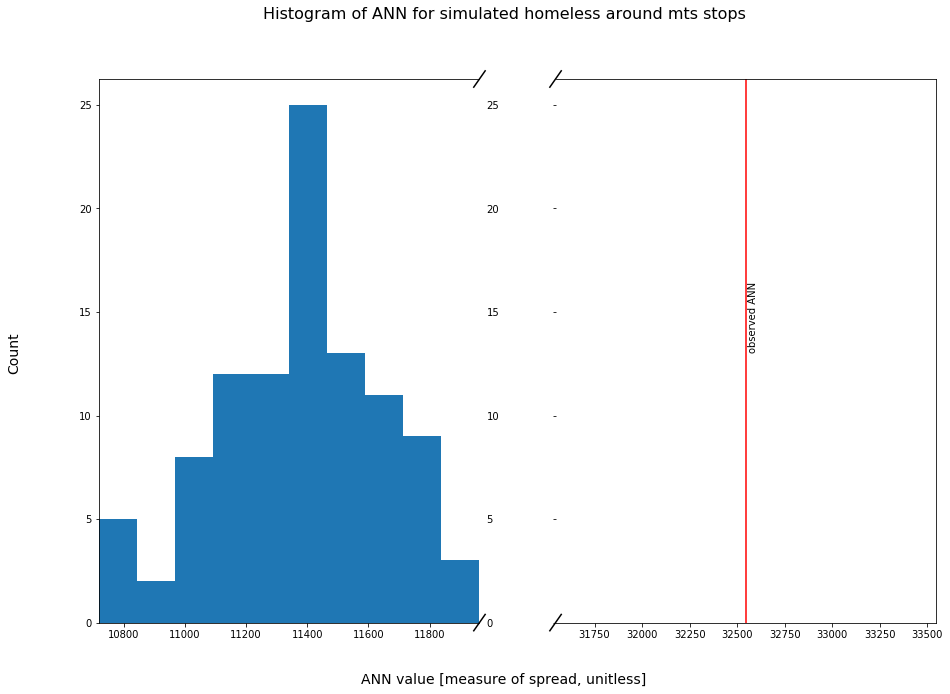

In [69]:
plot_simulated_ANNs_and_observed_ANN(simulated_ANNs, observed_ANN)


In [0]:
files.download('simulated_vs_observed_ANN.png')

In [0]:
### The final part of the project: redo the same analysis but with park stops in downtown SD:

# Park locations data originally downloaded from: http://seshat.datasd.org/sde/parks/parks_datasd.zip
files.upload()

In [0]:
parks_sd = gpd.read_file("parks_datasd.shp", crs={'init':'epsg:4326'})
parks_sd.head()

objectid  ...                                           geometry
0       273  ...  POLYGON ((6319812.252 1865054.231, 6319839.000...
1       291  ...  MULTIPOLYGON (((6320001.920 1870640.113, 63199...
2       383  ...  POLYGON ((6248545.000 1876201.000, 6248446.020...
3       384  ...  MULTIPOLYGON (((6279088.000 1869399.000, 62790...
4       385  ...  POLYGON ((6296597.619 1921738.206, 6296671.805...

[5 rows x 6 columns]

In [0]:
parks_sd['geometry'] = parks_sd['geometry'].centroid
parks_sd = parks_sd.to_crs({'init': 'epsg:4326'})

In [0]:
parks_sd.head()

objectid  ...                     geometry
0       273  ...  POINT (-117.03749 32.78134)
1       291  ...  POINT (-117.04198 32.79024)
2       383  ...  POINT (-117.26939 32.81085)
3       384  ...  POINT (-117.17061 32.79245)
4       385  ...  POINT (-117.11564 32.93523)

[5 rows x 6 columns]

In [0]:
parks_downtown_sd = get_ref_points_in_polygon(parks_sd)

In [0]:
parks_downtown_sd

objectid  ...                     geometry
0       413  ...  POINT (-117.16142 32.70805)
1       495  ...  POINT (-117.16514 32.71013)
2       533  ...  POINT (-117.16153 32.71539)
3       545  ...  POINT (-117.16785 32.71310)
4       546  ...  POINT (-117.16074 32.71060)
5       547  ...  POINT (-117.16638 32.71063)
6       682  ...  POINT (-117.16192 32.71279)
7       732  ...  POINT (-117.15708 32.72311)
8       761  ...  POINT (-117.16429 32.70982)

[9 rows x 6 columns]

In [0]:
parks_downtown_sd['lon'] = parks_downtown_sd['geometry'].x
parks_downtown_sd['lat'] = parks_downtown_sd['geometry'].y

In [0]:
parks_downtown_sd = parks_downtown_sd[['lon', 'lat', 'geometry']]

In [0]:
homeless_parks_heatmap = make_ref_points_basemap(ref_points_df = parks_downtown_sd)
random.seed(4)
homeless_lat_lon_df, homeless_array = getLatLonforHeatMap(homeless_df)
homeless_array_subset = homeless_array[random.sample(range(0,len(homeless_array)), 35000)]

# heatmap = HeatMap(homeless_array).add_to(m)
homeless_parks_heatmap.add_child(HeatMap(homeless_array_subset, radius=5))

# display heatmap
homeless_parks_heatmap

In [0]:
# get reference point densities for simulation
sd_park_density_df = get_ref_densities(parks_downtown_sd, homeless_lat_lon_df)

In [0]:
sd_park_density_df

lon        lat                     geometry   density
0 -117.161422  32.708047  POINT (-117.16142 32.70805)  0.119306
1 -117.165144  32.710125  POINT (-117.16514 32.71013)  0.070894
2 -117.161529  32.715392  POINT (-117.16153 32.71539)  0.258012
3 -117.167855  32.713100  POINT (-117.16785 32.71310)  0.049680
4 -117.160739  32.710595  POINT (-117.16074 32.71060)  0.173882
5 -117.166379  32.710630  POINT (-117.16638 32.71063)  0.050451
6 -117.161919  32.712792  POINT (-117.16192 32.71279)  0.175785
7 -117.157076  32.723112  POINT (-117.15708 32.72311)  0.018404
8 -117.164295  32.709815  POINT (-117.16429 32.70982)  0.083586

In [0]:
simulated_parks_points_df = get_simulated_points(ref_points_density_df = sd_park_density_df, border = None, total_points = 10000, upper_dist = 400)
simulated_parks_points_array = simulated_parks_points_df[['lat', 'lon']].values
simulated_parks_points_heatmap = make_ref_points_basemap()
simulated_parks_points_heatmap.add_child(HeatMap(simulated_parks_points_array, radius = 5))

In [0]:
simulated_ANNs = get_simulated_ANNs(ref_points_df = sd_park_density_df, number_of_cycles = 100, points_per_ref = 30)

In [0]:
observed_ANN = get_ANN(homeless_lat_lon_df, sd_park_density_df)

Calculated ANN for point 0 of 41052 in 0.008722782135009766 seconds
Calculated ANN for point 1000 of 41052 in 1.2532505989074707 seconds
Calculated ANN for point 2000 of 41052 in 2.463014602661133 seconds
Calculated ANN for point 3000 of 41052 in 3.7888150215148926 seconds
Calculated ANN for point 4000 of 41052 in 5.092791557312012 seconds
Calculated ANN for point 5000 of 41052 in 6.286445140838623 seconds
Calculated ANN for point 6000 of 41052 in 7.565226793289185 seconds
Calculated ANN for point 7000 of 41052 in 8.733195304870605 seconds
Calculated ANN for point 8000 of 41052 in 10.059777975082397 seconds
Calculated ANN for point 9000 of 41052 in 11.429149866104126 seconds
Calculated ANN for point 10000 of 41052 in 12.801049947738647 seconds
Calculated ANN for point 11000 of 41052 in 13.960064888000488 seconds
Calculated ANN for point 12000 of 41052 in 15.156623125076294 seconds
Calculated ANN for point 13000 of 41052 in 16.425346612930298 seconds
Calculated ANN for point 14000 of 41

In [0]:
plot_simulated_ANNs_and_observed_ANN(simulated_ANNs, observed_ANN)

TypeError: ignored

In [0]:
observed_ANN

1740.3668742422867

In [0]:
simulated_ANNs

In [0]:
parks_downtown_sd.head()

lon        lat                     geometry
0 -117.161422  32.708047  POINT (-117.16142 32.70805)
1 -117.165144  32.710125  POINT (-117.16514 32.71013)
2 -117.161529  32.715392  POINT (-117.16153 32.71539)
3 -117.167855  32.713100  POINT (-117.16785 32.71310)
4 -117.160739  32.710595  POINT (-117.16074 32.71060)

In [0]:
mts_stops_df.head()

lon        lat                     geometry
0 -117.240426  32.674458  POINT (-117.24043 32.67446)
1 -117.276187  32.839578  POINT (-117.27619 32.83958)
2 -117.273810  32.840128  POINT (-117.27381 32.84013)
3 -117.268673  32.845847  POINT (-117.26867 32.84585)
4 -117.262585  32.848826  POINT (-117.26259 32.84883)

In [0]:
parks_stops_df = 